<a href="https://colab.research.google.com/github/BuczynskiRafal/pipe_calculations/blob/main/OOP_Catchments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install extensions

In [60]:
!pip install pyswmm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import extensions

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyswmm import Simulation, Nodes, Links, Subcatchments, Output

# prepare methoed for sumulation

In [62]:
class PipeData:
    def __init__(self):
        self.flow_turn_sign = []
        self.flow_turns = []
        self.peak_depth = []
        self.peak_flow = []
        self.peak_flow_date = []
        self.peak_velocity = []
        self.time_capacity_limited = []
        self.time_courant_crit = []
        self.time_full_downstream = []
        self.time_full_flow = []
        self.time_full_upstream = []
        self.time_normal_flow = []


class CatchmentData:
    def __init__(self):
        self.runoff = []
        self.peak_runoff_rate = []
        self.infiltration = []
        self.evaporation = []


class Analyse:
    def __init__(self, file_path='example.inp'):
        self.pipe_data = PipeData()
        self.catchment_data = CatchmentData()
        self.slope = []
        self._file_path = file_path

    def show_subcatchment(self):
        with Simulation(self._file_path) as sim:
            return [subcatchment.subcatchmentid for subcatchment in Subcatchments(sim)]

    def show_conduits(self):
        with Simulation(self._file_path) as sim:
            return [conduit.linkid for conduit in Links(sim)]

    def simulation(self, conduit_id=None, subcatchment_id=None, min_slope=0.1, max_slope=100, step=0.1):
        counter = min_slope
        while counter < max_slope:
            self.slope.append(counter)
            with Simulation(self._file_path) as sim:
                conduit = Links(sim)[conduit_id]
                catchment = Subcatchments(sim)[subcatchment_id]
                catchment.slope = counter
                for _ in sim:
                    pass
                conduit_stats = conduit.conduit_statistics
                catchment_stats = catchment.statistics
                for key in vars(self.pipe_data):
                    getattr(self.pipe_data, key).append(conduit_stats[key])
                for key in vars(self.catchment_data):
                    getattr(self.catchment_data, key).append(catchment_stats[key])
            counter += step
        return None

# Do simulation

In [63]:
pipe = Analyse()
pipe.simulation("C3", "S1")

# Prepare dataframe



In [64]:
data = {"slope": pipe.slope, **vars(pipe.pipe_data), **vars(pipe.catchment_data)}
df_raw = pd.DataFrame(data=data)

# Data for work

In [65]:
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   slope                  1000 non-null   float64
 1   flow_turn_sign         1000 non-null   int64  
 2   flow_turns             1000 non-null   int64  
 3   peak_depth             1000 non-null   float64
 4   peak_flow              1000 non-null   float64
 5   peak_flow_date         1000 non-null   float64
 6   peak_velocity          1000 non-null   float64
 7   time_capacity_limited  1000 non-null   float64
 8   time_courant_crit      1000 non-null   float64
 9   time_full_downstream   1000 non-null   float64
 10  time_full_flow         1000 non-null   float64
 11  time_full_upstream     1000 non-null   float64
 12  time_normal_flow       1000 non-null   float64
 13  runoff                 1000 non-null   float64
 14  peak_runoff_rate       1000 non-null   float64
 15  infil

In [66]:
df.head()

,slope,flow_turn_sign,flow_turns,peak_depth,peak_flow,peak_flow_date,peak_velocity,time_capacity_limited,time_courant_crit,time_full_downstream,time_full_flow,time_full_upstream,time_normal_flow,runoff,peak_runoff_rate,infiltration,evaporation
0,0.1,-1,1,0.758234,1.309422,44729.024774,2.520361,0.0,0.0,0.0,0.116667,0.016667,2.388750,379.232016,0.732375,58.171137,0.0
1,0.2,-1,1,0.784354,1.399004,44729.024774,2.588784,0.0,0.0,0.0,0.111111,0.033333,2.388750,389.548955,0.837815,51.939255,0.0
2,0.3,-1,3,0.800408,1.462139,44729.024774,2.668363,0.0,0.0,0.0,0.105556,0.033333,2.394306,395.698111,0.904243,48.652223,0.0
3,0.4,-1,3,0.806381,1.508196,44729.024774,2.732058,0.0,0.0,0.0,0.105556,0.033333,2.394306,400.023432,0.952387,46.462952,0.0
4,0.5,-1,1,0.821302,1.594721,44729.024543,2.982855,0.0,0.0,0.0,0.122222,0.038889,2.388750,403.303949,0.989773,44.830143,0.0


In [67]:
df.shape

(1000, 17)

In [68]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
slope,1000.0,50.050000,28.881944,0.100000,25.075000,50.050000,75.025000,100.000000
flow_turn_sign,1000.0,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
flow_turns,1000.0,1.004000,0.089398,1.000000,1.000000,1.000000,1.000000,3.000000
peak_depth,1000.0,0.886008,0.008730,0.758234,0.887284,0.887393,0.887454,0.899430
peak_flow,1000.0,1.868965,0.041173,1.309422,1.874999,1.879495,1.880211,1.928176
peak_flow_date,1000.0,44729.024763,0.000050,44729.024543,44729.024774,44729.024774,44729.024774,44729.024774
peak_velocity,1000.0,3.184681,0.042510,2.520361,3.190000,3.190046,3.190201,3.192568
time_capacity_limited,1000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
time_courant_crit,1000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
time_full_downstream,1000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Remove unused columns

In [69]:
df.columns

Index(['slope', 'flow_turn_sign', 'flow_turns', 'peak_depth', 'peak_flow',
       'peak_flow_date', 'peak_velocity', 'time_capacity_limited',
       'time_courant_crit', 'time_full_downstream', 'time_full_flow',
       'time_full_upstream', 'time_normal_flow', 'runoff', 'peak_runoff_rate',
       'infiltration', 'evaporation'],
      dtype='object')

In [70]:
df.head()

,slope,flow_turn_sign,flow_turns,peak_depth,peak_flow,peak_flow_date,peak_velocity,time_capacity_limited,time_courant_crit,time_full_downstream,time_full_flow,time_full_upstream,time_normal_flow,runoff,peak_runoff_rate,infiltration,evaporation
0,0.1,-1,1,0.758234,1.309422,44729.024774,2.520361,0.0,0.0,0.0,0.116667,0.016667,2.388750,379.232016,0.732375,58.171137,0.0
1,0.2,-1,1,0.784354,1.399004,44729.024774,2.588784,0.0,0.0,0.0,0.111111,0.033333,2.388750,389.548955,0.837815,51.939255,0.0
2,0.3,-1,3,0.800408,1.462139,44729.024774,2.668363,0.0,0.0,0.0,0.105556,0.033333,2.394306,395.698111,0.904243,48.652223,0.0
3,0.4,-1,3,0.806381,1.508196,44729.024774,2.732058,0.0,0.0,0.0,0.105556,0.033333,2.394306,400.023432,0.952387,46.462952,0.0
4,0.5,-1,1,0.821302,1.594721,44729.024543,2.982855,0.0,0.0,0.0,0.122222,0.038889,2.388750,403.303949,0.989773,44.830143,0.0


In [71]:
df.drop(columns=['flow_turn_sign', 'flow_turns', 'time_capacity_limited', 'time_courant_crit', 'time_full_downstream', 'time_full_upstream'], axis=1, inplace=True)
df.head()

,slope,peak_depth,peak_flow,peak_flow_date,peak_velocity,time_full_flow,time_normal_flow,runoff,peak_runoff_rate,infiltration,evaporation
0,0.1,0.758234,1.309422,44729.024774,2.520361,0.116667,2.388750,379.232016,0.732375,58.171137,0.0
1,0.2,0.784354,1.399004,44729.024774,2.588784,0.111111,2.388750,389.548955,0.837815,51.939255,0.0
2,0.3,0.800408,1.462139,44729.024774,2.668363,0.105556,2.394306,395.698111,0.904243,48.652223,0.0
3,0.4,0.806381,1.508196,44729.024774,2.732058,0.105556,2.394306,400.023432,0.952387,46.462952,0.0
4,0.5,0.821302,1.594721,44729.024543,2.982855,0.122222,2.388750,403.303949,0.989773,44.830143,0.0


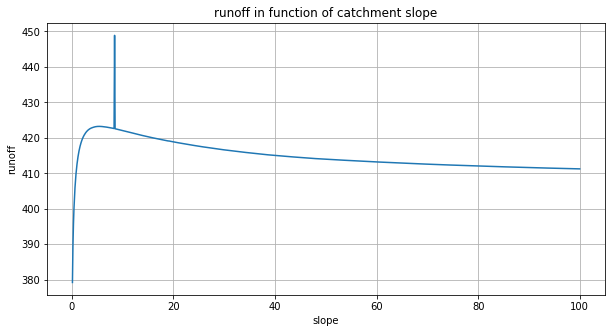

In [72]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['runoff'])
plt.title('runoff in function of catchment slope')
plt.xlabel('slope')
plt.ylabel('runoff')
plt.grid(True)
plt.show()

# Plot peak runoff rate data

In [73]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_runoff_rate'])
plt.title('peak runoff rate in function of catchment slope')
plt.xlabel('slope')
plt.ylabel('peak runoff rate')
plt.grid(True)
plt.show()

NameError: ignored

# Plot infiltration data

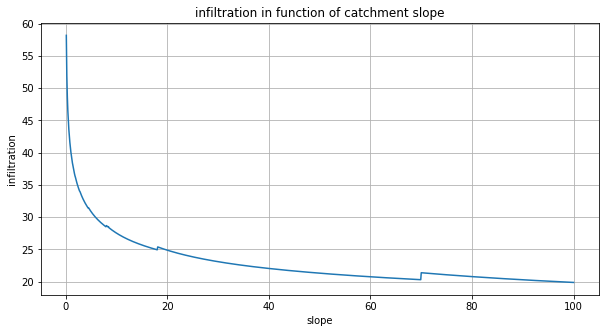

In [74]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['infiltration'])
plt.title('infiltration in function of catchment slope')
plt.xlabel('slope')
plt.ylabel('infiltration')
plt.grid(True)
plt.show()

# Plot pipe flow

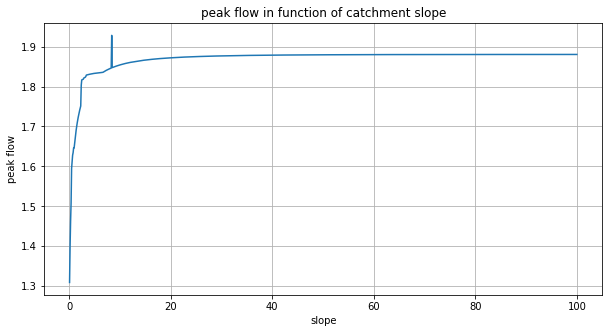

In [76]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_flow'])
plt.title('peak flow in function of catchment slope')
plt.xlabel('slope')
plt.ylabel('peak flow')
plt.grid(True)
plt.show()